# Mixing Station Workspace

***

Run the below code block to create a mixing_station instance, using the device names and com port addresses provided [here](data/devices/mixing_stations.json).

In [1]:
%load_ext autoreload
%autoreload 2

from src.robot_controller import scheduler

instance = scheduler.experiment(device_name="microtron_02", home=False)

2025-02-24 16:39:37 INFO: Located device data for microtron_02.
2025-02-24 16:39:37 INFO: No serial connection to fluid handling kit established.
2025-02-24 16:39:37 INFO: Configuring mass balance serial port..
2025-02-24 16:39:37 INFO: Attempting to open mass balance serial port..
2025-02-24 16:39:37 INFO: Serial connection to mass balance established.
2025-02-24 16:39:37 INFO: No serial connection to temperature controller established.
2025-02-24 16:39:37 INFO: Configuring gantry kit serial port..
2025-02-24 16:39:37 INFO: Attempting to open gantry kit serial port..
2025-02-24 16:39:37 INFO: Serial connection to gantry kit established.
2025-02-24 16:39:37 INFO: Configuring pipette serial port..
2025-02-24 16:39:37 INFO: Attempting to open pipette serial port..
2025-02-24 16:39:37 INFO: Disc pump successfully initialised.
2025-02-24 16:39:37 INFO: Disc pump drive mode succesfully configured.
2025-02-24 16:39:37 INFO: Disc pump PID settings succesfully configured.
2025-02-24 16:39:37 I

***

## Some Theory

The mixing station pulls information on each constituent electrolyte from a CSV file when creating a new electrolyte mixture. The constituents are numbered, which corresponds to the location of their container in the physical workspace. See the required information for each constituent below..

| # | Name | Dose Volume (uL) | Container Volume (mL) | Density (g/mL) | Aspirate Constant (mbar/uL) | Aspirate Speed (uL/s) |
| --- | --- | --- | --- | --- | --- | --- |

Based on the [literature](https://www.theleeco.com/uploads/2023/06/AN049-Pipetting-Disc-Pump-Application-Note-1.pdf), we can expect the aspirate constant to be roughly equal to the system pressure $P_r$ divided by the reservoir volume $V_r$. The system pressure can be assumed equal to atmospheric pressure $\approx$ 1000mbar and the chosen reservoir volume is 2500uL $\implies$ the constant should be about **0.4mbar/uL**.

$$ \Delta P_r = \frac{P_s}{V_r} V_{asp} $$ 

For more viscous liquids, this value may increase based on the ohm's law equivalent of fluid flow through a pipe (the Hagen-Poiseuille equation). To compensate for this, an extra variable is included to slow down the rate of aspiration in an attempt to lower the pressure change required to aspirate more viscous fluids. Along with the response time of the pressure PID controller, the aspirate speed will determine how quickly the pressure of the disc pump changes. A typical value would be **10uL/s**.

$$ \Delta P = \frac{8 \mu L}{\pi R^4} Q $$ 

***

## Tune Aspiration Variables

**The aspirate speed can be set to zero, to jump straight to the aspiration pressure, for low viscosity liquids.**

You can run the below code blocks to perform automatic tuning, where the machine will loop through the parameter ranges and use mass balance data to measure the errors. Tuning therefore requires the mass balance to be connected, and that the mixing chamber outputs to a container on the mass balance.

In [ ]:
%matplotlib inline
instance.tune(pot_number = 5, asp_speed = [100, 100], aspirate_volume = [100.0, 2000.0], container_volume = 37.8, density = 1.0, N = 1, M = 4)

2025-02-24 16:40:19 INFO: Tuning will perform a total of 12 aspirations: 24/02/2025 16:40:19
2025-02-24 16:40:19 INFO: Aspirating 100.0uL using parameters 0.0uL/s..
2025-02-24 16:40:21 INFO: Response from gantry kit: Move complete in 0s
2025-02-24 16:40:23 INFO: Moving to _..
2025-02-24 16:40:25 INFO: Response from gantry kit: Move complete in 1s
2025-02-24 16:40:25 INFO: Pipette successfully turned on.
2025-02-24 16:40:25 INFO: Pipette target gauge pressure set to 30mbar.
2025-02-24 16:40:25 INFO: Pipette reached 29.61mbar in less than 425ms.
2025-02-24 16:40:27 INFO: Final Pump values: 30.064mbar @ 57.842mW.
2025-02-24 16:40:27 INFO: Pipette charged.
2025-02-24 16:40:27 INFO: Dropping Pipette to -6.389950265882142mm..
2025-02-24 16:40:30 INFO: Response from gantry kit: Move complete in 2s
2025-02-24 16:40:30 INFO: Pipette target gauge pressure set to 65.89mbar.
2025-02-24 16:40:31 INFO: Pipette reached 65.614mbar in less than 635ms.
2025-02-24 16:40:33 INFO: Final Pump values: 66.044

SerialException: ClearCommError failed (PermissionError(13, 'The device does not recognize the command.', None, 22))

2025-02-24 17:12:14 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-24 17:12:14 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-24 17:12:14 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-24 17:12:14 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-24 17:12:14 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

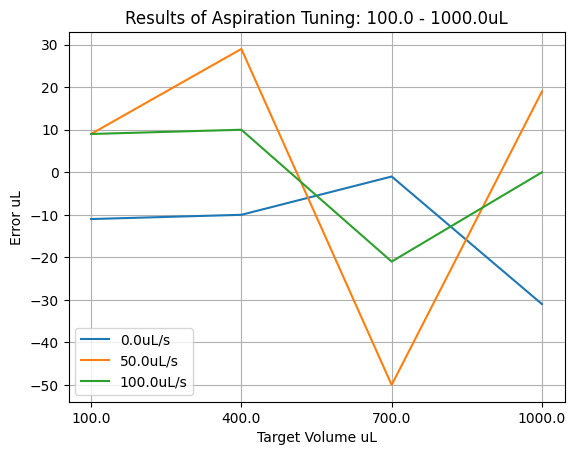

In [3]:
%matplotlib inline
instance.plot_aspiration_results("data/results/aspiration_tuning_results.csv")

### Update [this](data/CSVs/electrolyte_recipe.csv) CSV file with the chosen variables before beginning an experiment! 

***

## Run Experiment

Running the below code block will begin a single experiment that creates an electrolye mixture based on the volumes of constitutent electrolytes given in the [electrolyte receipe csv file](data/recipes/electrolyte_recipe.csv).

In [ ]:
instance.csv_filename = "electrolyte_recipe.csv"
instance.read_csv()

instance.run()

***

### Run life test

Run *N* number of experiments in succession, using the parameters defined in the [life test csv file](data/recipes/life_test.csv).

In [ ]:
instance.csv_filename = "life_test.csv"
instance.read_csv()

instance.run_life_test(N=1)

***

## Future Work

Once the viability of the Mixing Station has been validated, we can look to use an API to call `experiment.run()` via the [Atinary software](https://scientia.atinary.com/sdlabs/academic/dashboard), enabling a self-driving lab setup where the constituent volumes are updated with each run.